# Facial Keypoint Detection

This project attempts to perform image keypoint detection. It uses a very simple convolutional architecture, followed by a fully connected layer. Dataset contains images of faces, algorithm attempts to detect eyes, tip of nose, mouth.

Given the pretty small dataset (2000 images) and simple network architecture, it is surprising how well the net works!

### Loading and visualizing the data

This facial keypoints dataset consists gray images. All of these images are separated into either a training or a test set of data.



---

In [2]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from vis_utils import show_all_keypoints


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Training data size

The training data is in csv file. There are 6750 images in training data, where the first 30 columns are the keypoints coordinates (x, y)

(6451, 31)


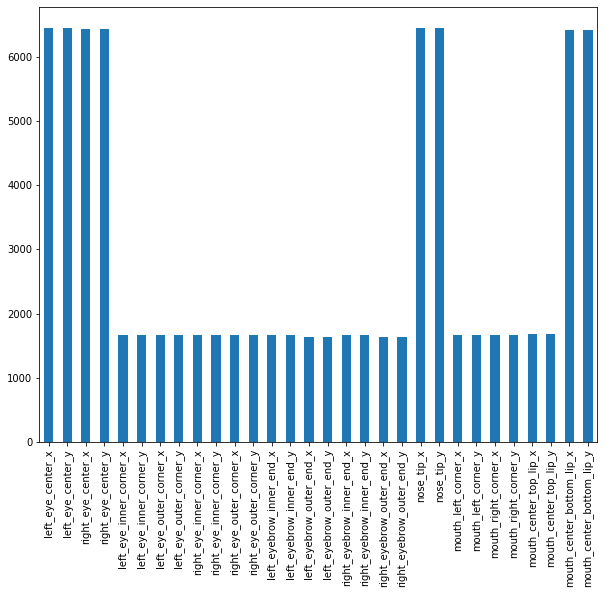

In [4]:
key_pts_frame = pd.read_csv('datasets/training.csv')
key_pts_frame.describe().loc['count'].plot.bar()
print(key_pts_frame.shape)

From visulization, we can see not every image contains full landmarks, therefore the images which do not have complete landmarks are dropped. And after dropping, we have almost 2k images left as our training data.

(1546, 31)


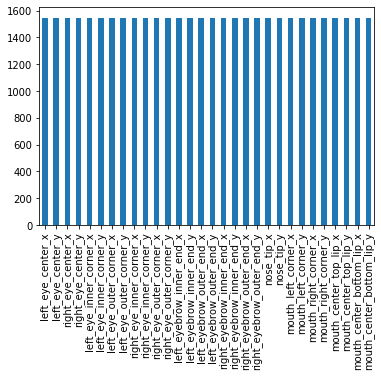

In [3]:
key_pts_frame.dropna(inplace=True)
key_pts_frame.describe().loc['count'].plot.bar()
print(key_pts_frame.shape)

In [5]:
from data_utils import get_keypoints
from data_utils import get_image

n = 0
image = get_image(n, key_pts_frame)
keypoints = get_keypoints(n, key_pts_frame)
print('image size: {}'.format(image.shape))
print('keypoints size: {}'.format(keypoints.shape))

image size: (96, 96)
keypoints size: (15, 2)


Data Visualization:

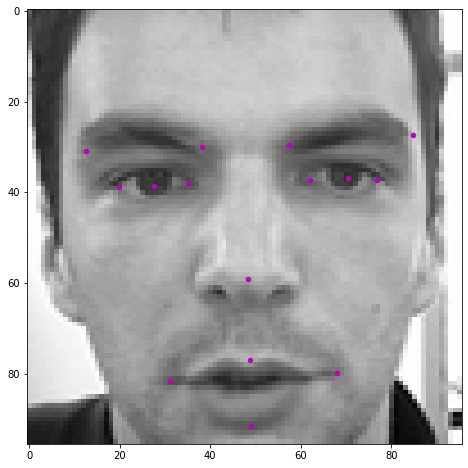

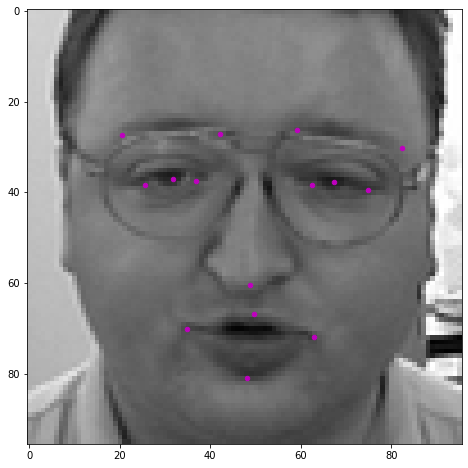

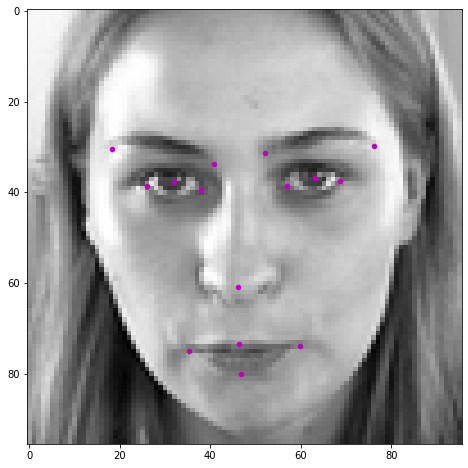

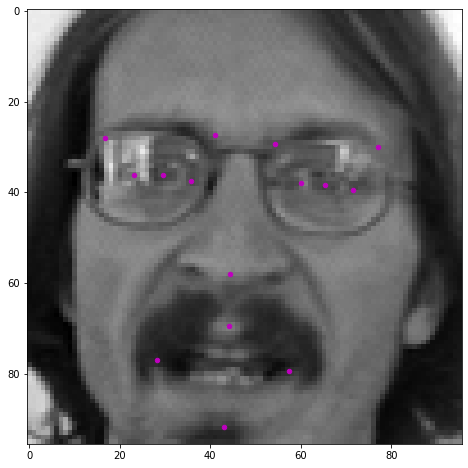

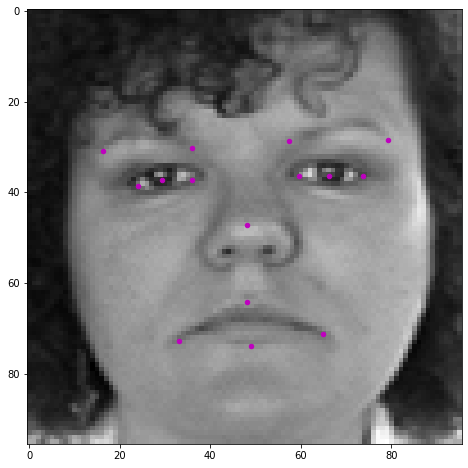

In [6]:
# select an image by index in our data frame
for n in range(5):
    image = get_image(n, key_pts_frame)
    key_pts = get_keypoints(n, key_pts_frame)
    show_all_keypoints(image, key_pts)

Loading of the data, using a custom implemented Dataloader:

In [12]:
from dataloader import FacialKeypointsDataset

# Construct the dataset
face_dataset = FacialKeypointsDataset(csv_file='datasets/training.csv')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  1546


Displaying some of the data:

index: 0
image size: (96, 96)
keypoint shape: (15, 2)


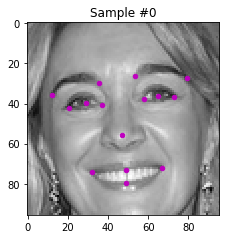

index: 1
image size: (96, 96)
keypoint shape: (15, 2)


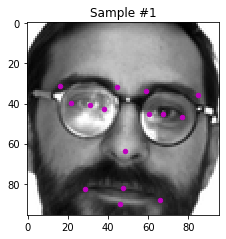

index: 2
image size: (96, 96)
keypoint shape: (15, 2)


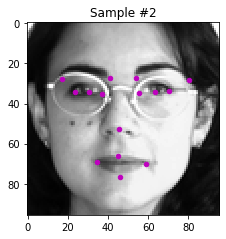

index: 3
image size: (96, 96)
keypoint shape: (15, 2)


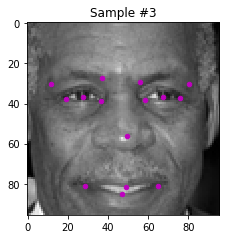

index: 4
image size: (96, 96)
keypoint shape: (15, 2)


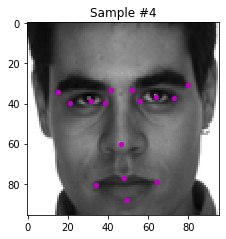

In [19]:
# Display a few of the images from the dataset
num_to_display = 5

for i in range(num_to_display):
    
    # define the size of images
    fig = plt.figure(figsize=(20,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # print the shape of the image and keypoints
    print('index: {}'.format(i))
    print('image size: {}'.format(sample['image'].shape))
    print('keypoint shape: {}'.format(sample['keypoints'].shape))

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    # Using the same display function, defined earlier
    
    show_all_keypoints(sample['image'], sample['keypoints'])


We also load the data using transforms that bring the images to the same dimensions and normalizes them:




In [21]:
import torch
from torchvision import transforms, utils

from transforms import Normalize, ToTensor

# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='datasets/training.csv',
                                             transform=data_transform)

In [22]:
from torch.utils.data import DataLoader
batch_size = 20
train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

This is the simple convolutional network used. BatchNorm is used to prevent overfitting and vanishing gradients

In [24]:
from keypoint_nn import KeypointModel
model = KeypointModel()
print(model)

KeypointModel(
  (conv_net): Sequential(
    (0): Conv2d(1, 30, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(30, 30, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_net): Sequential(
    (0): Linear(in_features=4860, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=30, bias=True)
    (3): Tanh()
  )
)


Again another visualization function used during debugging. Shows keypoint predictions before training the network: 

index: 4
image shape: torch.Size([96, 96])
gt keypoints shape: torch.Size([1, 15, 2])
predict keypoints shape: torch.Size([1, 15, 2])


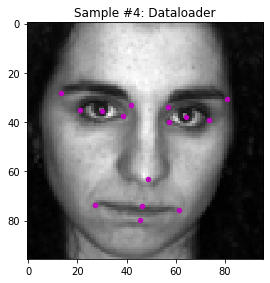

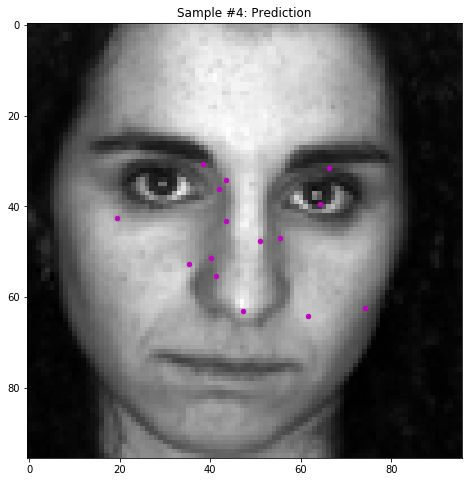

index: 4
image shape: torch.Size([96, 96])
gt keypoints shape: torch.Size([1, 15, 2])
predict keypoints shape: torch.Size([1, 15, 2])


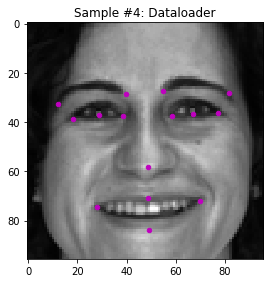

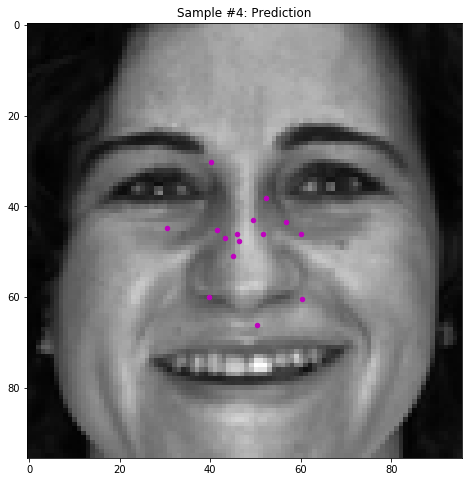

index: 4
image shape: torch.Size([96, 96])
gt keypoints shape: torch.Size([1, 15, 2])
predict keypoints shape: torch.Size([1, 15, 2])


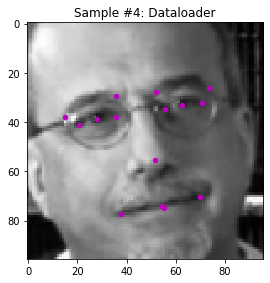

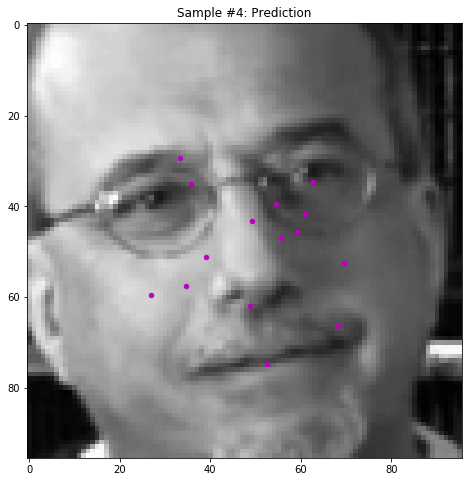

In [26]:
# Display a few output samples from our network
def show_sample_outputs(image, keypoints):    
    # define the size of images
    fig = plt.figure(figsize=(20,20))
    #print('debug.image shape is %s'%str(image.shape))
     
    # Predict with model
    predicted_keypoints = model(image)
    #print('debug.shape of predicted keypoints is %s'%str(predicted_keypoints.shape))
    # Cast back to (x,y)-coordinates
    predicted_keypoints = predicted_keypoints.view(1,-1, 2).detach()

    # Undo data normalization
    image = torch.squeeze(image) * 255.
    keypoints = (keypoints * 48) + 48
    predicted_keypoints = (predicted_keypoints * 48) + 48

    # print the shape of the image and keypoints
    print('index: {}'.format(i))
    print('image shape: {}'.format(image.shape))
    print('gt keypoints shape: {}'.format(keypoints.shape))
    print('predict keypoints shape: {}'.format(predicted_keypoints.shape))
    
    # Print data loader image
    ax = plt.subplot(4, 1, 1)
    ax.set_title('Sample #{}: Dataloader'.format(i))
    # Using the same display function, defined earlier
    show_all_keypoints(image, keypoints.squeeze())

    # Print predicted image
    ax = plt.subplot(1, 1, 1)
    ax.set_title('Sample #{}: Prediction'.format(i))
    # Using the same display function, defined earlier
    show_all_keypoints(image, predicted_keypoints.squeeze())
    plt.show()
    
num_to_display = 3
for idx, sample in enumerate(train_loader):
    if idx == num_to_display:
        break
    show_sample_outputs(sample['image'][0].unsqueeze(0), sample['keypoints'][0].unsqueeze(0))

### Training of the network
Using the pytorch framework

In [28]:
import torch.optim as optim
from torch import nn
from keypoint_nn import KeypointModel

def train_net(n_epochs):

    # prepare the net for training
    model.train()
    running_loss = 0.0
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            
            images = data['image']
            key_pts = data['keypoints']
            
            #print('debug. shape of keypoints=%s '%(str(key_pts.shape)))
            # flatten pts
            key_pts = key_pts.view(-1,30)
            #print('And after flattening: %s'%str(key_pts.shape))

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            #print(key_pts[0], images[0])

            # forward pass to get outputs
            output_pts = model(images)

            # calculate the loss between predicted and target keypoints
            #print('debug. shape of outputpts=%s, shape of keypoints=%s . They should match.'%(str(output_pts.shape),str(key_pts.shape)))
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
            running_loss += loss.item()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1,
                                                                   batch_i+1,
                                                                   running_loss / (len(train_loader)*epoch+batch_i)))
            
            #return images, key_pts, output_pts

    print('Finished Training')

    
# Load model and run the solver
model = KeypointModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6, nesterov=True)
train_net(n_epochs=15)

Epoch: 1, Batch: 10, Avg. Loss: 0.09856873750686646
Epoch: 1, Batch: 20, Avg. Loss: 0.06051165434090715
Epoch: 1, Batch: 30, Avg. Loss: 0.04607612087294973
Epoch: 1, Batch: 40, Avg. Loss: 0.03785647678738221
Epoch: 1, Batch: 50, Avg. Loss: 0.0328682467569502
Epoch: 1, Batch: 60, Avg. Loss: 0.02911995349736032
Epoch: 1, Batch: 70, Avg. Loss: 0.026279988394969183
Epoch: 2, Batch: 10, Avg. Loss: 0.02258162569233227
Epoch: 2, Batch: 20, Avg. Loss: 0.020952074078017288
Epoch: 2, Batch: 30, Avg. Loss: 0.01960337252538895
Epoch: 2, Batch: 40, Avg. Loss: 0.01848001865686005
Epoch: 2, Batch: 50, Avg. Loss: 0.017530860115341315
Epoch: 2, Batch: 60, Avg. Loss: 0.0166812196244778
Epoch: 2, Batch: 70, Avg. Loss: 0.015950662296163997
Epoch: 3, Batch: 10, Avg. Loss: 0.014815958242186091
Epoch: 3, Batch: 20, Avg. Loss: 0.014237626691215805
Epoch: 3, Batch: 30, Avg. Loss: 0.013727632363805094
Epoch: 3, Batch: 40, Avg. Loss: 0.01326050081361945
Epoch: 3, Batch: 50, Avg. Loss: 0.01284115620684333
Epoch: 

## Display the trained outputs

index: 0
image shape: torch.Size([96, 96])
gt keypoints shape: torch.Size([15, 2])
predict keypoints shape: torch.Size([1, 15, 2])


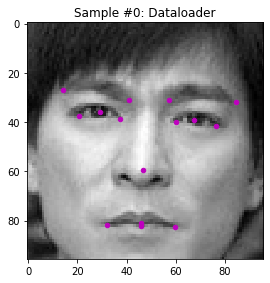

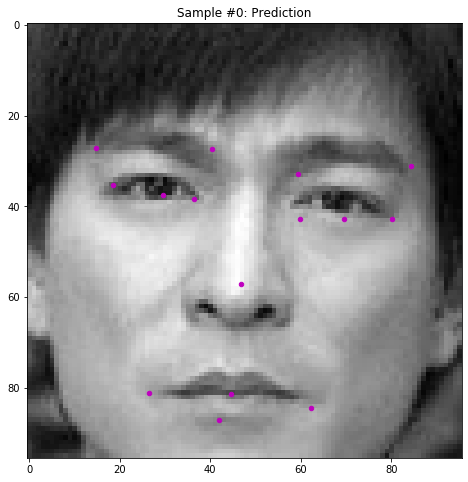

index: 1
image shape: torch.Size([96, 96])
gt keypoints shape: torch.Size([15, 2])
predict keypoints shape: torch.Size([1, 15, 2])


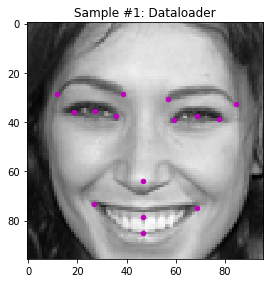

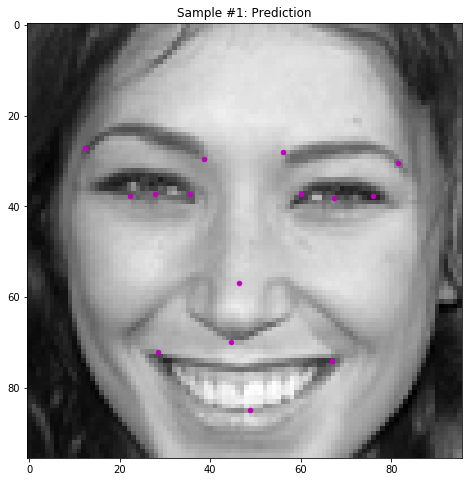

index: 2
image shape: torch.Size([96, 96])
gt keypoints shape: torch.Size([15, 2])
predict keypoints shape: torch.Size([1, 15, 2])


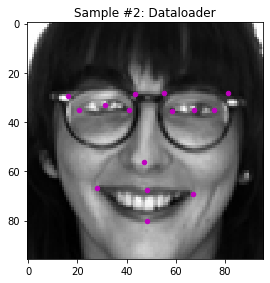

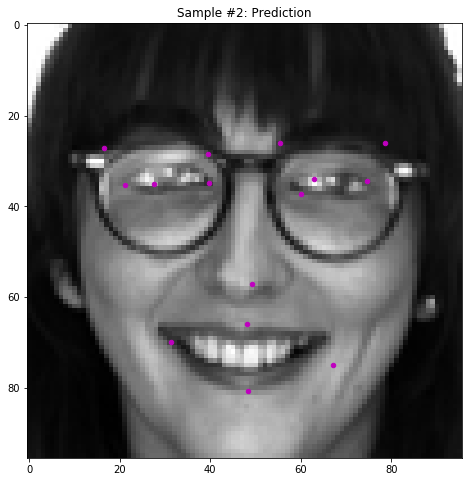

In [30]:
#show_sample_outputs(images[0:1], key_pts[0])

num_to_display = 3 
for i in range(num_to_display):
    sample = next(iter(train_loader))
    show_sample_outputs(sample['image'][0:1], sample['keypoints'][0])

## Validation on model
I have used the mean squared error (MSE) between the ground truth keypoint coordinate vector and the predicted keypoint coordinate vector as the metric. Given the ground truth vector and predict vector, MSE loss is defined as the average of the square of all of the error. 



In [31]:
def VAL_net():
    # prepare the net for training
    model.eval()
    running_loss = 0.0

    # train on batches of data, assumes you already have train_loader
    for batch_i, data in enumerate(val_loader):
        # get the input images and their corresponding labels
        images = data['image']
        key_pts = data['keypoints']

        # flatten pts
        key_pts = key_pts.view(key_pts.size(0), -1)

        # convert variables to floats for regression loss
        key_pts = key_pts.type(torch.FloatTensor)
        images = images.type(torch.FloatTensor)

        # forward pass to get outputs
        output_pts = model(images)

        # calculate the loss between predicted and target keypoints
        loss = criterion(output_pts, key_pts)

        # print loss statistics
        # to convert loss into a scalar and add it to the running_loss, use .item()
        running_loss += loss.item()
    # metric is 1 / (2 * MSE_loss)
    metric = 1.0 / (2 * (running_loss/len(val_loader)))
    print("Metric on VAL data: {}".format(metric))
    print('Finished Validation')
    
# create the validation dataset

VAL_dataset = FacialKeypointsDataset(csv_file='datasets/val.csv',
                                     transform=data_transform)
val_loader = DataLoader(VAL_dataset, 
                        batch_size=20,
                        shuffle=True, 
                        num_workers=4,
                        drop_last=True,
                       )
criterion = nn.MSELoss()
VAL_net()

Metric on VAL data: 239.6426819659737
Finished Validation
